   # ***McG-Coin PairGate (JPM-BAC) Strategy***
   

A **hybrid pairs strategy**: Cointegration spread + McGinley Dynamic trend filter + ML gatekeeper. 

**Tickers**: KO (Coca-Cola) & PEP (PepsiCo)

## Imports & Data Pulling

In [59]:
%pip install yfinance
%pip install matplotlib
%pip install statsmodels
%pip install scikit-learn


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: /opt/homebrew/opt/python@3.11/bin/python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: /opt/homebrew/opt/python@3.11/bin/python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: /opt/homebrew/opt/python@3.11/bin/python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: /opt/homebrew/opt/python@3.11/bin/python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import math

import yfinance as yf

import warnings
warnings.filterwarnings('ignore')

# stats & ml imports and warnings
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
try:
    from arch.unitroot import CADF
    HAVE_CADF = True
except Exception:
    HAVE_CADF = False

try:
    from statsmodels.tsa.vector_ar.vecm import coint_johansen
    HAVE_JOHANSEN = True
except Exception:
    HAVE_JOHANSEN = False

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.model_selection import TimeSeriesSplit

# xboost
try:
    from xgboost import XGBClassifier
    HAVE_XGB = True
except Exception:
    HAVE_XGB = False

In [61]:
tickers = ['JPM', 'BAC']
start = '2015-01-01'
end = None  # scrape up to today

def load_prices(tickers, start, end):
    data = yf.download(tickers, start=start, end=end, auto_adjust=False, progress=False)
    # account for splits/dividends
    if isinstance(data.columns, pd.MultiIndex):
        px = data['Adj Close'].copy()
    else:
        px = data['Adj Close'].to_frame()
    px = px.dropna(how='all')
    return px

prices = load_prices(tickers, start, end)
prices = prices.dropna()
prices.tail()


Ticker,BAC,JPM
Date,,
2025-09-16,50.660000,309.190002
2025-09-17,51.400002,311.750000
2025-09-18,52.130001,313.230011
2025-09-19,52.250000,314.779999
2025-09-22,51.919998,312.440002


## McGinley Dynamic Indicator

Formula (per 'Trading Strategy Guide'):

$$
\text{MD}_t = \text{MD}_{t-1} + \frac{\text{Price}_t - \text{MD}_{t-1}}{N \times \left(\frac{\text{Price}_t}{\text{MD}_{t-1}}\right)^4}
$$

- `N` is the smoothing factor (e.g., 10 for short-term, 14–20 for longer).
- We compute it per asset (KO and PEP).

In [62]:
def mcginley_dynamic(price: pd.Series, N: int = 14) -> pd.Series:
    md = np.zeros(len(price), dtype=float)
    p = price.values.astype(float)
    md[0] = p[0]
    for i in range(1, len(p)):
        prev = md[i-1]
        if prev == 0 or np.isclose(prev, 0.0):
            md[i] = p[i]
        else:
            md[i] = prev + (p[i] - prev) / (N * (p[i] / prev)**4)
    return pd.Series(md, index=price.index, name=f'MD_{price.name}_{N}')

md_N = 10 # represents short term movement
md = pd.DataFrame({t: mcginley_dynamic(prices[t], N=md_N) for t in tickers})
md.tail()

,JPM,BAC
Date,,
2025-09-16,299.833309,49.515010
2025-09-17,300.852955,49.677342
2025-09-18,301.906325,49.879607
2025-09-19,302.995663,50.076471
2025-09-22,303.830979,50.236003


## Engle-Granger Cointegration (ADF strategy)

In [63]:
def engle_granger_residuals(y: pd.Series, x: pd.Series):
    X = sm.add_constant(x.values)
    model = sm.OLS(y.values, X, missing='drop').fit()
    resid = pd.Series(model.resid, index=y.index, name=f'{y.name}_on_{x.name}_resid')
    return model, resid

def adf_test(series: pd.Series):
    adf_stat, pval, usedlag, nobs, crit, icbest = adfuller(series.dropna())
    return {'adf_stat': adf_stat, 'pval': pval, 'lags': usedlag, 'nobs': nobs, 'crit': crit}

ko, pep = prices['JPM'], prices['BAC']
m1, r1 = engle_granger_residuals(ko, pep)  # KO ~= a + (b * PEP)
m2, r2 = engle_granger_residuals(pep, ko)  # PEP ~= a + (b * KO)

t1 = adf_test(r1)
t2 = adf_test(r2)

best = ('JPM_on_BAC', r1, m1, t1) if t1['pval'] < t2['pval'] else ('BAC_on_JPM', r2, m2, t2)
which, spread, model_used, adf_used = best
print('Chosen regression:', which)
print('ADF p-value on residuals:', adf_used['pval'])
spread.name = 'spread'
spread = spread.dropna()
spread.tail()


Chosen regression: BAC_on_JPM
ADF p-value on residuals: 0.339764720015577


Date
2025-09-16   -5.374568
2025-09-17   -5.019728
2025-09-18   -4.512401
2025-09-19   -4.625603
2025-09-22   -4.603544
Name: spread, dtype: float64

## Z-score of spread & McGinley regime filter

- Z-score over rolling window (default 60).
- **Regime filter**: only allow trades when both KO and PEP are within ±1% of their McGinley line (to avoid strong trends).
- **Signals**:  
  - If z > +2 ⇒ short KO / long PEP (weighted by hedge ratio from regression used).  
  - If z < –2 ⇒ long KO / short PEP.
- **Exits**: when |z| ≤ 0.5 or max holding days reached.

In [64]:
lookback = 60
z = (spread - spread.rolling(lookback).mean()) / spread.rolling(lookback).std()
z = z.dropna().rename('z')

# regime filter: both within 1% of MD
md_dist = (prices / md - 1.0).abs()
regime_ok = (md_dist['JPM'] <= 0.01) & (md_dist['BAC'] <= 0.01)
regime_ok = regime_ok.reindex(z.index).fillna(False)

# hedge ratio from chosen regression - essentially slope
beta = model_used.params[1]
beta

np.float64(0.15045359859693058)

## ML Gatekeeper (defaulted Logistic Regression)

In [65]:
H = 5  # horizon to evaluate outcome
df = pd.concat([z, spread, md['JPM'], md['BAC'], prices['JPM'], prices['BAC']], axis=1).dropna()
df.columns = ['z','spread','md_jpm','md_bac','jpm','bac']

# Features
df['z_prev'] = df['z'].shift(1)
df['rv5'] = df['spread'].pct_change().rolling(5).std() * np.sqrt(252)
df['md_jpm_slope5'] = df['md_jpm'].diff(5) / 5.0
df['md_bac_slope5'] = df['md_bac'].diff(5) / 5.0

# Outcome: profit sign of idealized mean-reversion trade after H days
ret_jpm = df['jpm'].pct_change(H).shift(-H)
ret_bac = df['bac'].pct_change(H).shift(-H)
direction = np.sign(df['z'])
df['payoff_H'] = np.where(direction>=0, -ret_jpm + beta*ret_bac, ret_jpm - beta*ret_bac)

COST = 0.0005  # 5 bps round-trip placeholder
df['y'] = (df['payoff_H'] - COST) > 0

feat_cols = ['z','z_prev','rv5','md_jpm_slope5','md_bac_slope5']
ml = df.dropna(subset=feat_cols+['y']).copy()

X = ml[feat_cols].values
y = ml['y'].values.astype(int)

tscv = TimeSeriesSplit(n_splits=5)
proba = pd.Series(index=ml.index, dtype=float)

if HAVE_XGB:
    clf = XGBClassifier(
        n_estimators=200,
        max_depth=3,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        reg_lambda=1.0
    )
else:
    clf = LogisticRegression(max_iter=1000)

for train_idx, test_idx in tscv.split(X):
    clf.fit(X[train_idx], y[train_idx])
    p = clf.predict_proba(X[test_idx])[:,1]
    proba.iloc[test_idx] = p

ml['proba'] = proba
ml.tail()


,z,spread,md_jpm,md_bac,jpm,bac,z_prev,rv5,md_jpm_slope5,md_bac_slope5,payoff_H,y,proba
Date,,,,,,,,,,,,,
2025-09-16,0.384559,-5.374568,299.833309,49.515010,309.190002,50.660000,0.360904,0.865247,0.790954,0.124431,NaN,False,0.461100
2025-09-17,0.716713,-5.019728,300.852955,49.677342,311.750000,51.400002,0.384559,0.901181,0.907304,0.134508,NaN,False,0.429347
2025-09-18,1.172347,-4.512401,301.906325,49.879607,313.230011,52.130001,0.716713,1.222825,0.954483,0.144616,NaN,False,0.403623
2025-09-19,1.044511,-4.625603,302.995663,50.076471,314.779999,52.250000,1.172347,1.028863,1.000575,0.158591,NaN,False,0.438400
2025-09-22,1.040732,-4.603544,303.830979,50.236003,312.440002,51.919998,1.044511,0.819100,0.978711,0.166964,NaN,False,0.436232


## Backtest engine

Rules recap:
- Enter when:
  - |z| ≥ 2,
  - Regime filter is `True`, and
  - ML prob ≥ 0.6 (if ML is available for that date; otherwise skip ML check).
- Position:
  - If z ≥ 2: **short KO, long PEP×β**
  - If z ≤ -2: **long KO, short PEP×β**
- Exit:
  - When |z| ≤ 0.5 **or** max holding days (e.g., 10) is reached.
- PnL approximated using next-day to next-day returns for each leg.
- Simple constant-cost per full round-trip.

In [66]:
entry_z = 2.0
exit_z  = 0.5
max_hold = 10
COST_RT = 0.0005  # 5 bps per round-trip on notional

bt = pd.DataFrame(index=prices.index)
bt['JPM'] = prices['JPM']
bt['BAC'] = prices['BAC']
bt['z'] = z.reindex(bt.index)
bt['regime_ok'] = regime_ok.reindex(bt.index).fillna(False)
bt['proba'] = ml['proba'].reindex(bt.index)
bt['r_JPM'] = bt['JPM'].pct_change().fillna(0.0)
bt['r_BAC'] = bt['BAC'].pct_change().fillna(0.0)
bt['position'] = 0
bt['days_in'] = 0
bt['trade_flag'] = ''

in_pos = 0
days_in = 0
pnl_daily = []

for i in range(1, len(bt)):
    z_t = bt['z'].iloc[i]
    regime = bt['regime_ok'].iloc[i]
    proba_t = bt['proba'].iloc[i]
    r_jpm = bt['r_JPM'].iloc[i]
    r_bac= bt['r_BAC'].iloc[i]

    pos = in_pos
    flag = ''
    cost_today = 0.0  # accumulates entry/exit cost for this day

    # EXIT first
    if in_pos != 0:
        days_in += 1
        if (abs(z_t) <= exit_z) or (days_in >= max_hold):
            cost_today += COST_RT       # <-- charge cost once
            pos = 0
            days_in = 0
            flag = 'EXIT'

    # ENTRY if flat
    if pos == 0 and (not math.isnan(z_t)) and regime:
        allow = True
        if not math.isnan(proba_t):
            allow = proba_t >= 0.60
        if allow and abs(z_t) >= entry_z:
            pos = -1 if z_t > 0 else +1
            days_in = 0
            cost_today += COST_RT       # <-- charge cost once
            flag = 'ENTER'

    # Spread PnL for the day
    if pos == 0:
        ret = 0.0
    elif pos < 0:  # short KO, long PEP*beta
        ret = -r_jpm + beta * r_bac
    else:          # long KO, short PEP*beta
        ret = r_jpm - beta * r_bac

    # we only want 1 value per day
    pnl_daily.append(ret - cost_today)

    in_pos = pos
    bt.iloc[i, bt.columns.get_loc('position')] = pos
    bt.iloc[i, bt.columns.get_loc('days_in')] = days_in
    bt.iloc[i, bt.columns.get_loc('trade_flag')] = flag

# lengths should match here - no errors for pnl
pnl = pd.Series(pnl_daily, index=bt.index[1:], name='pnl')
bt = bt.iloc[1:]
bt['pnl'] = pnl.fillna(0.0)
bt['equity'] = (1 + bt['pnl']).cumprod()
bt.tail()


,JPM,BAC,z,regime_ok,proba,r_JPM,r_BAC,position,days_in,trade_flag,pnl,equity
Date,,,,,,,,,,,,
2025-09-16,309.190002,50.660000,0.384559,False,0.461100,0.000939,0.001384,0,0,,0.0,1.101812
2025-09-17,311.750000,51.400002,0.716713,False,0.429347,0.008280,0.014607,0,0,,0.0,1.101812
2025-09-18,313.230011,52.130001,1.172347,False,0.403623,0.004747,0.014202,0,0,,0.0,1.101812
2025-09-19,314.779999,52.250000,1.044511,False,0.438400,0.004948,0.002302,0,0,,0.0,1.101812
2025-09-22,312.440002,51.919998,1.040732,False,0.436232,-0.007434,-0.006316,0,0,,0.0,1.101812


## Performance Summary & Plots

Equity final: 1.102
Annualized return (approx): 1.22%
Sharpe (approx): 0.15
Max drawdown: -20.36%
Trades taken: 1


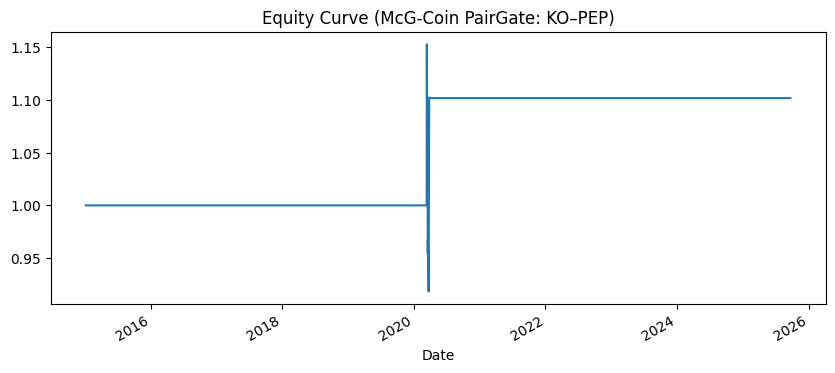

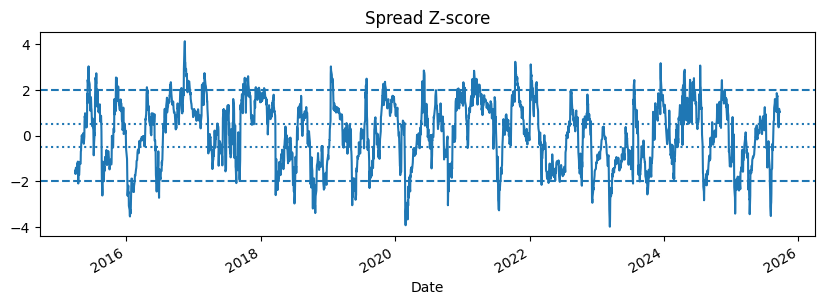

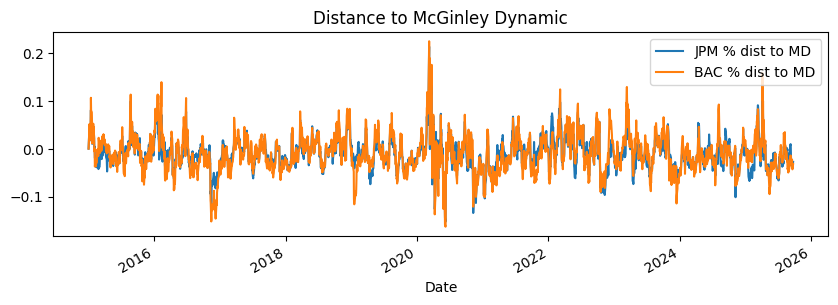

In [67]:
def sharpe_ratio(returns, periods_per_year=252, risk_free=0.0):
    er = returns.mean()*periods_per_year
    sr = (returns.mean() - risk_free/periods_per_year) / (returns.std() + 1e-12) * np.sqrt(periods_per_year)
    return er, sr

bt['ret'] = bt['pnl']
er, sr = sharpe_ratio(bt['ret'])
cum = (1 + bt['ret']).cumprod()
peak = cum.cummax()
dd = (cum/peak - 1.0)
max_dd = dd.min()

print('Equity final:', f"{bt['equity'].iloc[-1]:.3f}")
print('Annualized return (approx):', f"{er:.2%}")
print('Sharpe (approx):', f"{sr:.2f}")
print('Max drawdown:', f"{max_dd:.2%}")
print('Trades taken:', (bt['trade_flag']=='ENTER').sum())

fig, ax = plt.subplots(figsize=(10,4))
bt['equity'].plot(ax=ax, title='Equity Curve (McG-Coin PairGate: KO–PEP)')
plt.show()

fig, ax = plt.subplots(figsize=(10,3))
bt['z'].plot(ax=ax, title='Spread Z-score')
ax.axhline(2, ls='--'); ax.axhline(-2, ls='--'); ax.axhline(0.5, ls=':'); ax.axhline(-0.5, ls=':')
plt.show()

fig, ax = plt.subplots(figsize=(10,3))
((md['JPM']/prices['JPM'])-1).plot(ax=ax, label='JPM % dist to MD')
((md['BAC']/prices['BAC'])-1).plot(ax=ax, label='BAC % dist to MD')
ax.set_title('Distance to McGinley Dynamic')
ax.legend()
plt.show()


## Johansen Diagnostics

In [68]:
if HAVE_JOHANSEN:
    try:
        jj = coint_johansen(prices.dropna(), det_order=0, k_ar_diff=1)
        print('Johansen eigenvalues:', jj.eig)
    except Exception as e:
        print('Johansen error:', e)
else:
    print('Johansen not available in this environment.')


Johansen eigenvalues: [0.0038297  0.00132454]
